Author: K. Geil

Date: 03/2023

Description: verify we have all data files we need from the UNFAO group and check for data accessibility (loads correctly), dimensions, grid, and if any files are all nan 

Notes:

## Set up

In [1]:
import numpy as np
import glob

import rioxarray as rio
import xarray as xr

from natsort import natsorted 
# import dask.array as da


In [2]:
# notebook and data directory locations
work_dir='K:/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/'
# data_dir='C:/Users/kerrie/Documents/02_LocalData/DataDownload03152023/'
data_dir='C:/Users/kerrie.WIN/Documents/data/DataDownload03152023/'

# file name components
dataset='AgERA5'
experiment='Hist'
year='1980'
months=[str(x).rjust(2,'0') for x in np.arange(1,13)]
gridsize='5m'
file_ext_d='.pxv'
file_exts_m=['.rst','.rdc']
variables=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m']


## Check for missing data files

In [3]:
# search through all the climate data folders to see if each file we need exists
# save a list of data files that are missing
# there should be 12 rst/rdc files for each monthly climate variable

data_missing_m=[]
data_missing_d=[]
for var in variables:
    filename_d=var+'365_'+dataset+'_'+experiment+'_'+year+'_'+gridsize+file_ext_d
    filelist_d=glob.glob(data_dir+'Climate/daily/'+filename_d)
    if not filelist_d:
        data_missing_d.append(filename_d)
            
    for month in months:
        for file_ext_m in file_exts_m:
            filename_m=var+'_'+dataset+'_'+experiment+'_'+year+'_'+month+'_'+gridsize+file_ext_m
            filelist_m=glob.glob(data_dir+'Climate/monthly/'+filename_m)
            if not filelist_m:
                data_missing_m.append(filename_m)


print('the following monthly climate files are missing:')
print(data_missing_m)
print('the following daily climate files are missing:')
print(data_missing_d)


the following monthly climate files are missing:
[]
the following daily climate files are missing:
['Wind-10m365_AgERA5_Hist_1980_5m.pxv']


## Which packages read .rst and .pxv?

In [4]:
# infile='Climate/monthly/Precip_AgERA5_Hist_1980_01_5m.rst'
infile='ALOSdem5m_fill.rst'
ds=rio.open_rasterio(data_dir+infile).squeeze()
ds

<xarray.DataArray (y: 2160, x: 4320)>
[9331200 values with dtype=int16]
Coordinates:
    band         int32 1
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Attributes:
    _FillValue:    -9999
    scale_factor:  1.0
    add_offset:    0.0
    units:         m

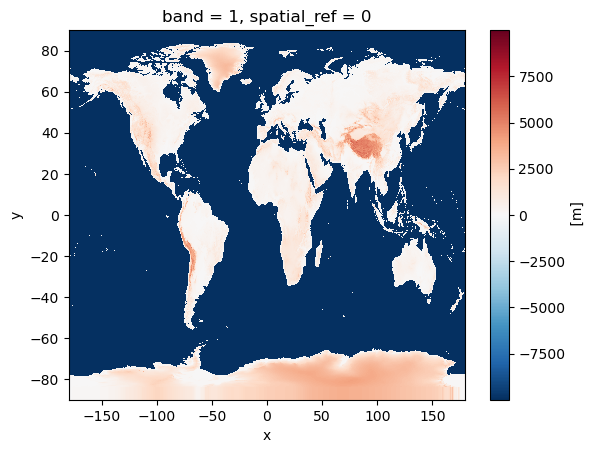

In [5]:
ds.plot()


rioxarray keeps the fill value at -9999. so the plot looks wrong unless you do an extra mask or convert fill value to nan

In [6]:
# infile='Climate/monthly/Precip_AgERA5_Hist_1980_01_5m.rst'
infile='ALOSdem5m_fill.rst'
ds=xr.open_dataset(data_dir+infile,engine='rasterio').squeeze()
ds

<xarray.Dataset>
Dimensions:      (x: 4320, y: 2160)
Coordinates:
    band         int32 1
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 ...
Data variables:
    band_data    (y, x) float32 ...

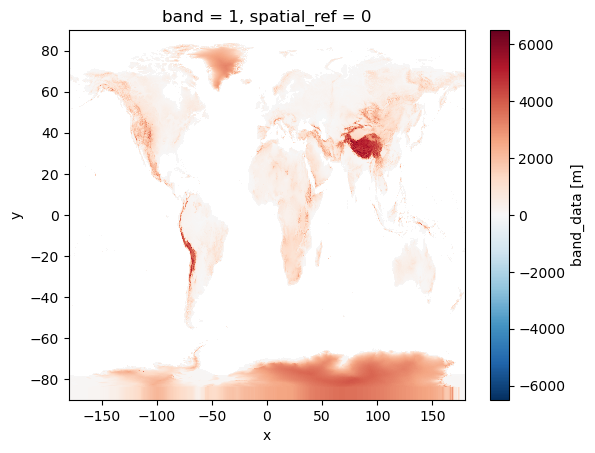

In [7]:
ds.band_data.plot()

both rioxarray and xarray work to open rst/rdc files. 

xarray may be nicer because: 
- you can squeeze singleton dims, 
- it gives the data a variable name (band_data), and 
- it automatically updates the fill value to nan so that it plots correctly without having to do anything
- there may be parallelization/chunking benefits too

### *what about pxv? I can't find any info on how to open pxv with python*

## Check file integrity

(make sure we can open each file, access the data, dimensions are the same across all files, and no file contain all nan)

In [8]:
# loop thru each monthly climate file, load data, print dimsize to make sure nothing errors, check that dims are equal across all files
file_ext_m=file_exts_m[0] # select only the .rst extension

# get a list of the non climate files
nonclimlist=glob.glob(data_dir+'*.rst')

# get a list of all the climate files, append non climate files
filename='*_'+dataset+'_'+experiment+'_'+year+'_*_'+gridsize+file_ext_m
filelist=natsorted(glob.glob(data_dir+'Climate/monthly/'+filename))
filelist=filelist+nonclimlist

# get the data dimensions of the first file
dims=ds=xr.open_dataset(filelist[0],engine='rasterio').squeeze().band_data.shape
lats=xr.open_dataset(filelist[0],engine='rasterio').squeeze().band_data.y.data
lons=xr.open_dataset(filelist[0],engine='rasterio').squeeze().band_data.x.data

# check if all files open without error and have same dims
errfiles=[] # list to collect files that error
diffdims=[] # list to collect files with different data dims
nanfiles=[] # list to collect files that are all nan
latfiles=[] # list to collect files with different grid lats
lonfiles=[] # list to collect files with different grid lons
for f in filelist:
    try:
        d=xr.open_dataset(f,engine='rasterio').squeeze().band_data

        dimcheck=d.shape
        if dimcheck != dims:
            diffdims.append(f)

        nancheck=d.isnull().all()
        if nancheck:
            nanfiles.append(f)

        latcheck=np.array_equal(lats,d.y.data)        
        if not latcheck:
            latfiles.append(f)

        loncheck=np.array_equal(lons,d.x.data)        
        if not loncheck:
            lonfiles.append(f)

    except:
        errfiles.append(f)

# print error, dims, and nan info
if errfiles:
    print('the following files could not be opened:')
    print(errfiles)
else:
    print('all files opened successfully')

if diffdims:
    print('the following files did not match the dimensions of the first file:')
    print(diffdims)
else:
    print('all files have the same dimensions')

if nanfiles:
    print('the following files contain all nan:')
    print(nanfiles)
else:
    print('no files are all nan')

if latfiles:
    print('the following files contain different grid latitudes:')
    print(latfiles)
else:
    print('all files have the same grid latitudes')

if lonfiles:
    print('the following files contain different grid longitudes:')
    print(lonfiles)
else:
    print('all files have the same grid longitudes')    

all files opened successfully
all files have the same dimensions
no files are all nan
all files have the same grid latitudes
all files have the same grid longitudes


### monthly data and non climate files look ready to use. Still need to figure out pxv file type (daily climate files)